# Bioassay Report Generator

This **jupyter notebook** should be run within a **virtual environment, Python2 (w2p27)**.

Here's how to open the notebook from the terminal:

````
aubrey@aubrey-Latitude-7280:~/fix-bioassay-db$ workon w2p27
(w2p27) aubrey@aubrey-Latitude-7280:~/fix-bioassay-db$ jupyter notebook
````

# Imports

In [64]:
#%matplotlib inline
import pandas as pd
import sqlite3
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy.stats as ss
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
import subprocess
import re
import os.path

import lifelines
from lifelines import KaplanMeierFitter, statistics

#pd.options.display.max_rows = 8

# Utility Functions

In [65]:
def tex_escape(text):
    """
        :param text: a plain text message
        :return: the message escaped to appear correctly in LaTeX
    """
    conv = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\^{}',
        '\\': r'\textbackslash{}',
        '<': r'\textless{}',
        '>': r'\textgreater{}',
    }
    regex = re.compile('|'.join(re.escape(unicode(key)) for key in sorted(conv.keys(), key = lambda item: - len(item))))
    return regex.sub(lambda match: conv[match.group()], text)

# Database

In [66]:
dbpath = 'databases/storage.sqlite'
conn = sqlite3.connect(dbpath)

# List Bioassays

In [67]:
sql ="""
SELECT
    bioassay_name
FROM
    btl
GROUP BY bioassay_name
ORDER BY bioassay_name
"""
df = pd.read_sql_query(sql, conn)
pd.options.display.max_rows = 1000
df

,bioassay_name
0,None
1,DUG42-1
2,DUG42-2
3,MALB-1
4,MALB-2
5,MALBperOS-1
6,PNG-1
7,PNG-2
8,PNG-3
9,PNG-4


# Parameters

In [68]:
# Bioassay_name must be assigned a value from the data frame above.
# To generate a report which includes all replicates in a bioassay use a wild card, example: DUG42-%

#bioassay_name = 'DUG42-%' #OK
#bioassay_name = 'MALB-%' #OK
#bioassay_name = 'MALBperOS-%' # DID NOT RUN
#bioassay_name = 'PNG-%' #OK
#bioassay_name = 'PNGperOS' #DID NOT RUN
#bioassay_name = 'V23B-%' #OK
#bioassay_name = 'V23B_large_bioassay-%' #OK
#bioassay_name = 'V23B_perOSIN-%' # DID NOT RUN
#bioassay_name = 'V23BperOS-%' # OK

notebook_version = 'v.2019-10-28'
github_repo = 'https://github.com/aubreymoore/rearing3'

title = bioassay_name.replace('-%', '')
title = tex_escape(title)
outputfile = 'bioassay-{}.pdf'.format(title)
outputfile_url = '{}/raw/master/{}'.format(github_repo, outputfile)

path_to_postmortem_images = 'uploads'
image_limit = 1000 # maximum number of post mortem images to include in report

# Summary Section

In [69]:
sql = """
SELECT
    *
FROM
    bioassay;
""".format(title)
df = pd.read_sql_query(sql, conn)
pd.options.display.max_rows = 1000
df

,id,name,tex
0,1,Vx23BperOS,\section{Laboratory experiment to evaluate the...
1,3,DUG42,\section{Description}\r\nAdult beetles incubat...
2,4,MALB,\section{Description}\r\n\r\n Adult beetles in...
3,5,PNG,\section{Description}\r\n Adult beetles incuba...
4,6,V23B,\section{Description}\r\n\r\n\r\n Adult beetle...
5,7,V23B_perOS-2,\section{Laboratory experiment to evaluate the...
6,8,V23B_perOSIN-1,Fifteen adult beetles maintained for more than...
7,9,Mal B perOSI-1,Fifteen adult beetles maintained for more than...
8,10,V23B -large bioassay test-1,Sixty adult beetles maintained for more than 2...


In [70]:
s = bioassay_name.split('-')[0]
try:
    summary = df[df.name==s].tex.values[0]
except:
    summary = 'Summary not available for "{}"'.format(s)
    summary = tex_escape(summary)
#print(summary)

In [71]:
summary_section_tex = r'''
\clearpage
\section{Summary}
---summary---
'''

summary_section_tex = summary_section_tex.replace('---summary---', summary)
#print(summary_section_tex)

# Mass Section

In [72]:
sql ="""
    SELECT 
        date_observed,
        date_start_bioassay,
        bioassay_treatment,
        julianday(date_observed) - julianday(date_start_bioassay) AS days,
        btl, mass
    FROM btl, obs
    WHERE
        btl.id = obs.btl
    AND
        bioassay_name LIKE '{}'
    AND mass IS NOT NULL
    ORDER BY btl, date_observed;
""".format(bioassay_name)
df = pd.read_sql_query(sql, conn)
pd.options.display.max_rows = 8
df

,date_observed,date_start_bioassay,bioassay_treatment,days,btl,mass
0,2019-03-05,2019-03-05,control,0.0,1393,4329
1,2019-03-07,2019-03-05,control,2.0,1393,4289
2,2019-03-09,2019-03-05,control,4.0,1393,4219
3,2019-03-11,2019-03-05,control,6.0,1393,4387
...,...,...,...,...,...,...
286,2019-05-02,2019-04-12,heat-inactivated,20.0,1446,3988
287,2019-05-05,2019-04-12,heat-inactivated,23.0,1446,4059
288,2019-05-07,2019-04-12,heat-inactivated,25.0,1446,3922
289,2019-05-09,2019-04-12,heat-inactivated,27.0,1446,3885


In [73]:
df['change_in_mass_per_day'] = df['mass'].diff()/df['days']
df = df[df.days>0]
pd.options.display.max_rows = 8
df

,date_observed,date_start_bioassay,bioassay_treatment,days,btl,mass,change_in_mass_per_day
1,2019-03-07,2019-03-05,control,2.0,1393,4289,-20.000000
2,2019-03-09,2019-03-05,control,4.0,1393,4219,-17.500000
3,2019-03-11,2019-03-05,control,6.0,1393,4387,28.000000
4,2019-03-13,2019-03-05,control,8.0,1393,4662,34.375000
...,...,...,...,...,...,...,...
286,2019-05-02,2019-04-12,heat-inactivated,20.0,1446,3988,-8.400000
287,2019-05-05,2019-04-12,heat-inactivated,23.0,1446,4059,3.086957
288,2019-05-07,2019-04-12,heat-inactivated,25.0,1446,3922,-5.480000
289,2019-05-09,2019-04-12,heat-inactivated,27.0,1446,3885,-1.370370


In [74]:
# Remove outliers

percentile1 = df["change_in_mass_per_day"].quantile(0.01)
percentile99 = df["change_in_mass_per_day"].quantile(0.99)
original_row_count = df.shape[0]
df = df[df.change_in_mass_per_day.between(percentile1, percentile99)]
final_row_count = df.shape[0]
print('Removing outliers from the change_in_mass_per_day column')
print('Original row count: {}'.format(original_row_count))
print('Final row count: {}'.format(final_row_count))
print('Outliers removed: {}'.format(original_row_count - final_row_count))

Removing outliers from the change_in_mass_per_day column
Original row count: 261
Final row count: 255
Outliers removed: 6


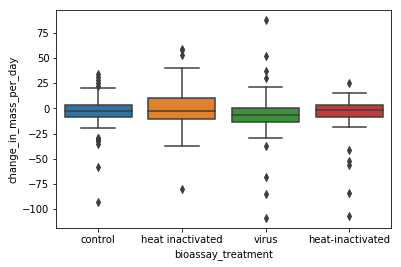

In [75]:
bp = sns.boxplot(x="bioassay_treatment", y="change_in_mass_per_day", data=df)
bp.figure.savefig('bp.pdf')

In [76]:
control = df[df.bioassay_treatment=='control'].change_in_mass_per_day.values
virus = df[df.bioassay_treatment=='virus'].change_in_mass_per_day.values
r = ss.kruskal(control, virus)
r

KruskalResult(statistic=2.7867866414204947, pvalue=0.09504464213136962)

In [77]:
mass_pairwise_results = sp.posthoc_dunn(df, val_col='change_in_mass_per_day', group_col='bioassay_treatment', p_adjust = 'holm')

In [78]:
mass_pairwise_results_tex = mass_pairwise_results.to_latex()
print(mass_pairwise_results_tex)

\begin{tabular}{lrrrr}
\toprule
{} &   control &  heat inactivated &  heat-inactivated &     virus \\
\midrule
control          & -1.000000 &          1.000000 &          1.000000 &  0.560673 \\
heat inactivated &  1.000000 &         -1.000000 &          1.000000 &  0.259404 \\
heat-inactivated &  1.000000 &          1.000000 &         -1.000000 &  0.812923 \\
virus            &  0.560673 &          0.259404 &          0.812923 & -1.000000 \\
\bottomrule
\end{tabular}



In [79]:
change_in_mass_section_tex = r'''
\clearpage
\section{Change in Mass}

\begin{center}
     \includegraphics[width=\textwidth]{bp.pdf}
\end{center}

\begin{table}[h!]
    \centering
    \caption{Results of pairwise significance tests for differences in change in mass.}
---mass pairwise results---
\end{table}
'''
# print(change_in_mass_section_tex)
change_in_mass_section_tex = change_in_mass_section_tex.replace('---mass pairwise results---', mass_pairwise_results_tex)
# print(change_in_mass_section_tex)

# Tex preamble, titlepage and TOC

In [80]:
preamble_tex = r'''
\documentclass[11pt]{scrartcl}
\usepackage{textcomp}
\usepackage{gensymb}
\usepackage{graphicx}
\usepackage{grffile} %required because there are multiple dot characters in my file names
\usepackage{booktabs}
\usepackage[letterpaper, margin=1in]{geometry}

\usepackage[unicode=true,pdfusetitle,
bookmarks=true,bookmarksnumbered=false,bookmarksopen=false,
breaklinks=true,pdfborder={0 0 0},pdfborderstyle={},backref=false,colorlinks=true]
{hyperref}
\hypersetup{linkcolor=blue,citecolor=blue,urlcolor=blue}
        
\titlehead{\centering\includegraphics[width=0.75in]{static/images/crb_logo.png}\\
University of Guam Coconut Rhinoceros Beetle Biological Control Project\\
Generated by bioassay-report-generator.ipynb ---notebook_version---\\
\url{---github_repo---}}

\title{Bioassay Report: ---title---}

\author{Aubrey Moore and James Grasela\\University of Guam Coconut Rhinoceros Beetle Biocontrol Project}
'''

preamble_tex = preamble_tex.replace('---title---', title)
preamble_tex = preamble_tex.replace('---notebook_version---', notebook_version)
preamble_tex = preamble_tex.replace('---github_repo---', github_repo)

#print(preamble_tex)

In [81]:
titlepage_tex = r'''
\begin{titlepage}
    \maketitle
    \begin{center}
        \url{---outputfile_url---}
    \end{center}
    \tableofcontents
\end{titlepage}
'''
titlepage_tex = titlepage_tex.replace('---outputfile_url---', outputfile_url)

#print(titlepage_tex)

# Mortality Section

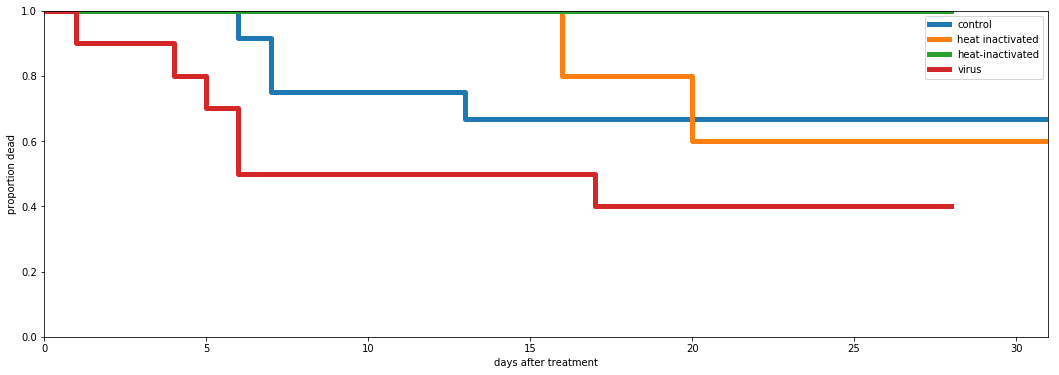

In [82]:
sql = "SELECT * FROM btl WHERE bioassay_name LIKE '{}'".format(bioassay_name)
df = pd.read_sql_query(sql, conn)    
#print(df)

t, e = lifelines.utils.datetimes_to_durations(
    start_times=pd.to_datetime(df.date_start_bioassay),
    end_times=pd.to_datetime(df.date_died),
    fill_date=pd.to_datetime(df.date_end_bioassay))
df['t'] = t
df['e'] = e

# Create survorship plot
fig, ax = plt.subplots(figsize=(18,6))
kmf = KaplanMeierFitter()
for name, grouped_df in df.groupby('bioassay_treatment'):
    kmf.fit(grouped_df['t'], grouped_df['e'], label=name)
    kmf.plot(ax=ax, linewidth=5, ci_show=False)
ax.set_xlabel('days after treatment')
ax.set_ylabel('proportion dead')
ax.set_ylim([0,1])
fig.savefig('survivorshipfig.pdf')

# Create motality-table-tex
results = statistics.pairwise_logrank_test(df['t'], df['bioassay_treatment'], df['e'])
s = r'''
    \begin{table}[h!]
    \centering
    \caption{Pairwise differences among mortality curves.}
'''
s += results.summary.to_latex()
s += '\end{table}'
mortality_pairwise_table_tex = s
#print(s)

In [83]:
sql = """
SELECT 
    bioassay_treatment, COUNT(*) AS ntotal
FROM
    btl
WHERE 
    bioassay_name LIKE '{}'
GROUP BY bioassay_treatment
ORDER BY bioassay_treatment;
""".format(bioassay_name)    
df_total = pd.read_sql_query(sql, conn)    
df_total

,bioassay_treatment,ntotal
0,control,12
1,heat inactivated,5
2,heat-inactivated,5
3,virus,10


In [84]:
sql = """
SELECT 
    bioassay_treatment, COUNT(*) AS ndead
FROM
    btl
WHERE 
    bioassay_name LIKE '{}'
AND
    date_died IS NOT NULL
GROUP BY bioassay_treatment
ORDER BY bioassay_treatment;
""".format(bioassay_name)    
df_dead = pd.read_sql_query(sql, conn)    
df_dead

,bioassay_treatment,ndead
0,control,4
1,heat inactivated,2
2,virus,6


In [85]:
def fisher(r, cdead, calive):
    return ss.fisher_exact([ [r.ntotal-r.ndead, r.ndead], [calive, cdead]])[1]

# Treatment mortality is adjusted for control mortality
# See http://www.ehabsoft.com/ldpline/onlinecontrol.htm

df = df_total.merge(df_dead)
df['mortality'] = df.ndead/df.ntotal
control_mortality = df[df.bioassay_treatment=='control'].mortality.values[0]
df['adjusted_mortality'] = (df.mortality-control_mortality)/(1-control_mortality)
ctotal = df[df.bioassay_treatment=='control'].ntotal
cdead = df[df.bioassay_treatment=='control'].ndead
calive = ctotal-cdead
df['significance'] = df.apply(fisher, axis=1, cdead=cdead, calive=calive)
mortality_table_tex = df.to_latex()
df

,bioassay_treatment,ntotal,ndead,mortality,adjusted_mortality,significance
0,control,12,4,0.333333,0.0,1.000000
1,heat inactivated,5,2,0.400000,0.1,1.000000
2,virus,10,6,0.600000,0.4,0.391284


In [86]:
mortality_section_tex = r'''
\clearpage
\section{Mortality}

\begin{table}[h!]
    \centering
    \caption{Mortality summary.}
    ---mortality_table_tex---
\end{table}

\begin{center}
     \includegraphics[width=\textwidth]{survivorshipfig.pdf}
\end{center}


---mortality_pairwise_table_tex--- 
'''

mortality_section_tex = mortality_section_tex.replace('---mortality_table_tex---', mortality_table_tex)
mortality_section_tex = mortality_section_tex.replace('---mortality_pairwise_table_tex---', 
                                                      mortality_pairwise_table_tex)
#print(mortality_section_tex)

# Post mortem images section

In [87]:
def get_postmortem_images(bioassay_name_pattern, image_limit):
    """
    """
    
    # get data
    
    sql = """
    SELECT id, bioassay_name, bioassay_treatment, pm_image
    FROM btl
    WHERE bioassay_name LIKE '{}' 
        AND pm_image IS NOT NULL AND pm_image != ''
    LIMIT {};
    """.format(bioassay_name_pattern, image_limit)
    df = pd.read_sql_query(sql, conn) 
    #rows = db.executesql(sql, as_dict=True)
    #df = pd.DataFrame(rows)
    df.dropna(inplace=True)
    if df.empty:
        tex = r'No post mortem images have been uploaded for this bioassay.' + '\n'
        return tex

    # generate tex
    
    tex = ''
    for treatment in df.bioassay_treatment.unique():
        tex += r'\subsection{' + treatment + r'}' + '\n\n'
        for index, row in df[df.bioassay_treatment==treatment].iterrows():
            fname = '{}/{}'.format(path_to_postmortem_images, row.pm_image)
            if os.path.isfile(fname): 
                tex += r'\begin{figure}[h!]' + '\n'
                tex += r'    \centering' + '\n'
                tex += r'    \includegraphics[width=\linewidth, height=\textheight, keepaspectratio]{' + fname + r'}' + '\n'
                tex += r'    \caption{Bioassay: ' + row.bioassay_name + '; Treatment: ' + row.bioassay_treatment + r'; Beetle ID: ' + str(row.id) + r'}' + '\n'
                tex += r'\end{figure}' + '\n'
            else:
                tex += r'ERROR: ' + fname + r' does not exist.' + '\n'
                print('{} does not exist.'.format(fname))
            tex += r'\clearpage' + '\n\n'
    return tex

#print get_postmortem_images(bioassay_name, 1000)

In [88]:
post_mortem_section_tex = r'''
\clearpage
\section{Post Mortem Images}
---post_mortem_section---
'''

post_mortem_section_tex = post_mortem_section_tex.replace('---post_mortem_section---', 
                                                          get_postmortem_images(bioassay_name, image_limit))
                                                          
#print(post_mortem_section_tex)

# Generate PDF

In [89]:
# Write report.tex
# I wrote it like this so that sections can easily be disabled by commenting out with a #

s = preamble_tex
s += r'\begin{document}'
s += titlepage_tex
s += summary_section_tex
s += mortality_section_tex
s += change_in_mass_section_tex
s += post_mortem_section_tex
s += r'\end{document}'
#print(s)

with open('report.tex', "w") as f:
    f.write(s)

In [90]:
# Generate PDF

result = subprocess.call(['pdflatex', 'report.tex'])
result = subprocess.call(['pdflatex', 'report.tex'])
#result = subprocess.call(['xdg-open', 'report.pdf'])
#return response.stream('report.pdf')

In [91]:
# Compress PDF and save in file named "bioassay-title.pdf"
subprocess.call(['gs',
                 '-sDEVICE=pdfwrite',
                 '-dPrinted=false',
                 '-dCompatibilityLevel=1.4',
                 '-dPDFSETTINGS=/ebook',
                 '-dNOPAUSE',
                 '-dQUIET', 
                 '-dBATCH',
                 '-sOutputFile={}'.format(outputfile),
                 'report.pdf'])

0

In [92]:
result = subprocess.call(['xdg-open', outputfile])